In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score
from PIL import Image

In [ ]:
!pip install roboflow tensorflow matplotlib scikit-learn pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 111.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [ ]:

from roboflow import Roboflow

rf = Roboflow(api_key="cD3caFq7wr9pBKnRVHHH")  # Use your API key
project = rf.workspace("roboflow-100").project("furniture-ngpea")
version = project.version(2)
dataset = version.download("coco")

print("Dataset downloaded!")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to furniture-2 in coco:: 100%|██████████| 697/697 [00:00<00:00, 4219.08it/s]


Dataset downloaded!


In [ ]:
import os

# List all directories and files in /content
print("Root directory contents:", os.listdir("/content"))

# Check if each item is a directory before listing its contents
for folder in os.listdir("/content"):
    folder_path = os.path.join("/content", folder)
    if os.path.isdir(folder_path):  # Check if it is a directory
        print(f"Contents of {folder_path}:", os.listdir(folder_path))
    else:
        print(f"{folder_path} is a file.")


Root directory contents: ['.config', 'furniture-2', 'gdrive', 'sample_data']
Contents of /content/.config: ['.last_opt_in_prompt.yaml', 'gce', 'active_config', 'default_configs.db', '.last_survey_prompt.yaml', '.last_update_check.json', 'hidden_gcloud_config_universe_descriptor_data_cache_configs.db', 'config_sentinel', 'configurations', 'logs']
Contents of /content/furniture-2: ['README.roboflow.txt', 'train', 'valid', 'test', 'README.dataset.txt']
Contents of /content/gdrive: ['MyDrive', '.file-revisions-by-id', '.shortcut-targets-by-id', '.Trash-0', '.Encrypted']
Contents of /content/sample_data: ['README.md', 'anscombe.json', 'california_housing_train.csv', 'california_housing_test.csv', 'mnist_test.csv', 'mnist_train_small.csv']


In [ ]:
import zipfile

dataset_path = "/content/furniture-2"  # Change if needed

# Check if the dataset exists
if os.path.exists(dataset_path):
    print("Dataset already extracted!")
else:
    zip_file = dataset_path + ".zip"  # Update if file name is different
    if os.path.exists(zip_file):
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall("/content/")
        print("Dataset extracted successfully!")
    else:
        print("Dataset ZIP file not found. Re-download the dataset.")


Dataset already extracted!


In [ ]:
print("Train contents:", os.listdir(dataset_path + "/train"))
print("Valid contents:", os.listdir(dataset_path + "/valid"))


Train contents: ['Chair--128-_jpg.rf.7e2f327445b2141956ea0407409ea183.jpg', 'Sofa--350-_jpg.rf.afca5f82670c13bd4afbda3cbc386b2a.jpg', 'Chair--75-_jpg.rf.30781a32e53b84537cc6d8bee343e727.jpg', 'Table--142-_jpg.rf.9afededdfc9164713bd9b04b7753d909.jpg', 'Chair--137-_jpg.rf.b7848c56680bd7ce3bbb712a1a038731.jpg', 'Sofa--316-_jpg.rf.19d2472cde857a302e5e999546a7e256.jpg', 'Sofa--253-_jpg.rf.858c7b5456913666393b765c9ac6c3de.jpg', 'Sofa--283-_jpg.rf.2a09fdf82de126ba5caf440f0c033466.jpg', 'Sofa--308-_jpg.rf.f4f3f456f4ea790f411b0f54db4231de.jpg', 'Table--132-_jpg.rf.8d9a8bbde5b53ce8963ec7d7c10c77e6.jpg', 'Sofa--268-_jpg.rf.181ae697986bd305624076f9e29efbd0.jpg', 'Chair--169-_jpg.rf.9d6e5d800b7ca7300690c303808b84fd.jpg', 'Table--105-_jpg.rf.58b42f699665af9ddf27ed3ebc080c2e.jpg', 'Chair--78-_jpg.rf.bc1f414c09e606335cd1a791c3c20ab0.jpg', 'Sofa--276-_jpg.rf.e54074e2735ea13e53da2d03f47973af.jpg', 'Sofa--155-_jpg.rf.2898eee5e1b37cbfc91ccb6f2b4ce3b7.jpg', 'Sofa--233-_jpg.rf.2e590ade61953a8638b712734849a9

In [ ]:
import os
import shutil

valid_path = "/content/furniture-2/valid"

# Normalize class folder names (lowercase, singular form if needed)
for folder in os.listdir(valid_path):
    folder_path = os.path.join(valid_path, folder)

    # Skip JSON files or non-directory files
    if not os.path.isdir(folder_path) or folder.endswith(".json"):
        continue

    # Standardize folder name
    clean_name = folder.lower().rstrip('s')  # Convert to lowercase and remove extra 's'
    new_folder_path = os.path.join(valid_path, clean_name)

    # If a corrected folder already exists, move files into it
    if folder_path != new_folder_path:
        if os.path.exists(new_folder_path):
            for file in os.listdir(folder_path):
                shutil.move(os.path.join(folder_path, file), new_folder_path)
            os.rmdir(folder_path)  # Remove the old incorrect folder
        else:
            os.rename(folder_path, new_folder_path)  # Rename it directly

print("Validation dataset folders fixed!")


Validation dataset folders fixed!


In [ ]:
import os

train_path = "/content/furniture-2/train"
valid_path = "/content/furniture-2/valid"

print("Train Directory:", os.listdir(train_path))
print("Valid Directory:", os.listdir(valid_path))


Train Directory: ['Chair--128-_jpg.rf.7e2f327445b2141956ea0407409ea183.jpg', 'Sofa--350-_jpg.rf.afca5f82670c13bd4afbda3cbc386b2a.jpg', 'Chair--75-_jpg.rf.30781a32e53b84537cc6d8bee343e727.jpg', 'Table--142-_jpg.rf.9afededdfc9164713bd9b04b7753d909.jpg', 'Chair--137-_jpg.rf.b7848c56680bd7ce3bbb712a1a038731.jpg', 'Sofa--316-_jpg.rf.19d2472cde857a302e5e999546a7e256.jpg', 'Sofa--253-_jpg.rf.858c7b5456913666393b765c9ac6c3de.jpg', 'Sofa--283-_jpg.rf.2a09fdf82de126ba5caf440f0c033466.jpg', 'Sofa--308-_jpg.rf.f4f3f456f4ea790f411b0f54db4231de.jpg', 'Table--132-_jpg.rf.8d9a8bbde5b53ce8963ec7d7c10c77e6.jpg', 'Sofa--268-_jpg.rf.181ae697986bd305624076f9e29efbd0.jpg', 'Chair--169-_jpg.rf.9d6e5d800b7ca7300690c303808b84fd.jpg', 'Table--105-_jpg.rf.58b42f699665af9ddf27ed3ebc080c2e.jpg', 'Chair--78-_jpg.rf.bc1f414c09e606335cd1a791c3c20ab0.jpg', 'Sofa--276-_jpg.rf.e54074e2735ea13e53da2d03f47973af.jpg', 'Sofa--155-_jpg.rf.2898eee5e1b37cbfc91ccb6f2b4ce3b7.jpg', 'Sofa--233-_jpg.rf.2e590ade61953a8638b712734849a

In [ ]:
import os
import shutil

# Paths to training and validation datasets
dataset_paths = {
    "train": "/content/furniture-2/train",
    "valid": "/content/furniture-2/valid"
}

# Define class names
classes = ["Chair", "Sofa", "Table"]

# Ensure class folders exist in both train and valid sets
for dataset, path in dataset_paths.items():
    for class_name in classes:
        os.makedirs(os.path.join(path, class_name), exist_ok=True)

# Function to sort images into class folders
def sort_images(dataset_path):
    for file in os.listdir(dataset_path):
        file_path = os.path.join(dataset_path, file)

        # Move only files (not directories)
        if os.path.isfile(file_path):

            # Ensure the file is not already inside a class folder
            if os.path.dirname(file_path) in [os.path.join(dataset_path, c) for c in classes]:
                continue  # Skip files already inside class folders

            # Case-insensitive matching (e.g., "office_chair.jpg" will be sorted)
            for class_name in classes:
                if class_name.lower() in file.lower():
                    dest_folder = os.path.join(dataset_path, class_name)
                    shutil.move(file_path, os.path.join(dest_folder, file))
                    print(f"Moved {file} → {dest_folder}")  # Debugging line
                    break  # Stop checking after moving the file

# Sort images in both train and valid folders
for path in dataset_paths.values():
    sort_images(path)

print("Images sorted into class folders for both train and valid sets!")


Moved Chair--128-_jpg.rf.7e2f327445b2141956ea0407409ea183.jpg → /content/furniture-2/train/Chair
Moved Sofa--350-_jpg.rf.afca5f82670c13bd4afbda3cbc386b2a.jpg → /content/furniture-2/train/Sofa
Moved Chair--75-_jpg.rf.30781a32e53b84537cc6d8bee343e727.jpg → /content/furniture-2/train/Chair
Moved Table--142-_jpg.rf.9afededdfc9164713bd9b04b7753d909.jpg → /content/furniture-2/train/Table
Moved Chair--137-_jpg.rf.b7848c56680bd7ce3bbb712a1a038731.jpg → /content/furniture-2/train/Chair
Moved Sofa--316-_jpg.rf.19d2472cde857a302e5e999546a7e256.jpg → /content/furniture-2/train/Sofa
Moved Sofa--253-_jpg.rf.858c7b5456913666393b765c9ac6c3de.jpg → /content/furniture-2/train/Sofa
Moved Sofa--283-_jpg.rf.2a09fdf82de126ba5caf440f0c033466.jpg → /content/furniture-2/train/Sofa
Moved Sofa--308-_jpg.rf.f4f3f456f4ea790f411b0f54db4231de.jpg → /content/furniture-2/train/Sofa
Moved Table--132-_jpg.rf.8d9a8bbde5b53ce8963ec7d7c10c77e6.jpg → /content/furniture-2/train/Table
Moved Sofa--268-_jpg.rf.181ae697986bd3056

In [ ]:
for class_name in classes:
    class_path = os.path.join(train_path, class_name)
    print(f"{class_name} Images: {os.listdir(class_path)}")


Chair Images: ['Chair--128-_jpg.rf.7e2f327445b2141956ea0407409ea183.jpg', 'Chair--75-_jpg.rf.30781a32e53b84537cc6d8bee343e727.jpg', 'Chair--137-_jpg.rf.b7848c56680bd7ce3bbb712a1a038731.jpg', 'Chair--169-_jpg.rf.9d6e5d800b7ca7300690c303808b84fd.jpg', 'Chair--78-_jpg.rf.bc1f414c09e606335cd1a791c3c20ab0.jpg', 'Chair--146-_jpg.rf.0812b1fb2e10a93eb3d3cb33b812209c.jpg', 'Chair--131-_jpg.rf.f089cd4c172be76a12a8bfb79b096c9c.jpg', 'Chair--219-_jpg.rf.aa2fb5d4700cf0d3dc8c683033d9b2a9.jpg', 'Chair--8-_jpg.rf.87c0e2de5d6087044376d78ef0cdf4f4.jpg', 'Chair--210-_jpg.rf.2bd6ae0a81c671650c978d308280d9d8.jpg', 'Chair--41-_jpg.rf.de82da0d829e0589f3009f7113178fc5.jpg', 'Chair--1-_jpg.rf.90233c5326ce5a78f92717fcb0e5e996.jpg', 'Chair--265-_jpg.rf.6c8dc56444b22d243729e8be5e5be8ff.jpg', 'Chair--59-_jpg.rf.c05c6a56e2b0ad7ea528e6311c699eed.jpg', 'Chair--262-_jpg.rf.a70878c05b1db79ecf1b152bd8f14461.jpg', 'Chair--28-_jpg.rf.d505117ca276adb21c4597d5cb04e335.jpg', 'Chair--52-_jpg.rf.0d08ba23092e7ae78a4b19780745ab1

In [ ]:
import os
import shutil

valid_path = "/content/furniture-2/valid"

# Correct class names
class_renames = {
    "sofa": "Sofa",
    "table": "Table",
    "chair": "Chair"
}

# Rename incorrect folders
for wrong_name, correct_name in class_renames.items():
    wrong_path = os.path.join(valid_path, wrong_name)
    correct_path = os.path.join(valid_path, correct_name)

    if os.path.exists(wrong_path):
        shutil.move(wrong_path, correct_path)
        print(f"✅ Renamed: {wrong_name} ➝ {correct_name}")

# Remove unwanted files
json_file = os.path.join(valid_path, "_annotations.coco.json")
if os.path.exists(json_file):
    os.remove(json_file)
    print("🗑️ Removed: _annotations.coco.json")

print("🎯 Validation dataset cleaned successfully!")


🗑️ Removed: _annotations.coco.json
🎯 Validation dataset cleaned successfully!


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(
    train_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode="categorical"
)

val_data = datagen.flow_from_directory(
    valid_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode="categorical"
)


Found 454 images belonging to 3 classes.
Found 161 images belonging to 3 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#Build CNN model correctly
model = Sequential([
    # Custom Layer 1
    Conv2D(filters=3, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Custom Layer 2
    Conv2D(filters=3, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Custom Layer 3
    Conv2D(filters=3, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),  # Prevents overfitting
    Dense(3, activation='softmax')  # 3 output classes
])

#Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Model Summary
model.summary()


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 3)      │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 3)      │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 3)      │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 108)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,423 (29.00 KB)

 Trainable params: 7,423 (29.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the CNN
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=25  # Adjust epochs as needed
)


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 515ms/step - accuracy: 0.3146 - loss: 1.1170 - val_accuracy: 0.1429 - val_loss: 1.2957
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 347ms/step - accuracy: 0.4332 - loss: 1.0422 - val_accuracy: 0.1429 - val_loss: 1.5685
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.4500 - loss: 1.0091 - val_accuracy: 0.1429 - val_loss: 1.6821
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.4515 - loss: 1.0283 - val_accuracy: 0.1429 - val_loss: 1.7620
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - accuracy: 0.4924 - loss: 1.0252 - val_accuracy: 0.1429 - val_loss: 1.6007
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step - accuracy: 0.5642 - loss: 0.9651 - val_accuracy: 0.1366 - val_loss: 1.6664
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.6062 - loss: 0.9708 - val_accuracy: 0.1366 - val_loss: 1.6459
Epoch 8/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 253ms/step - accuracy: 0.5785 - loss: 0.9431 - val_accuracy: 0

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Resize images to 250x250 with RGB mode
datagen = ImageDataGenerator(rescale=1./255)

train_data_rgb = datagen.flow_from_directory(
    train_path,
    target_size=(250, 250),
    batch_size=32,
    class_mode="categorical"
)

val_data_rgb = datagen.flow_from_directory(
    valid_path,
    target_size=(250, 250),
    batch_size=32,
    class_mode="categorical"
)


Found 454 images belonging to 3 classes.
Found 161 images belonging to 3 classes.


In [ ]:
# Build CNN model for 250x250 RGB images
model_rgb = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_rgb.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_rgb = model_rgb.fit(train_data_rgb, validation_data=val_data_rgb, epochs=25)


Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 677ms/step - accuracy: 0.4374 - loss: 5.1831 - val_accuracy: 0.3478 - val_loss: 1.2274
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 283ms/step - accuracy: 0.8329 - loss: 0.4979 - val_accuracy: 0.1429 - val_loss: 2.1070
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 308ms/step - accuracy: 0.8730 - loss: 0.3323 - val_accuracy: 0.5280 - val_loss: 1.7475
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 352ms/step - accuracy: 0.9392 - loss: 0.1715 - val_accuracy: 0.5217 - val_loss: 1.8377
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step - accuracy: 0.9832 - loss: 0.0845 - val_accuracy: 0.5714 - val_loss: 1.7223
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 400ms/step - accuracy: 0.9806 - loss: 0.0553 - val_accuracy: 0.5963 - val_loss: 1.6301
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 295ms/step - accuracy: 0.9910 - loss: 0.0353 - val_accuracy: 0.4907 - val_loss: 2.4194
Epoch 8/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 289ms/step - accuracy: 0.9896 - loss: 0.0642 - val_accuracy: 0

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step


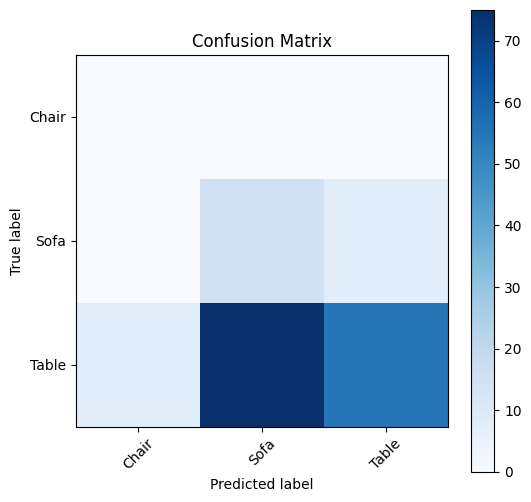

No positive samples in y_true, true positive value should be meaningless


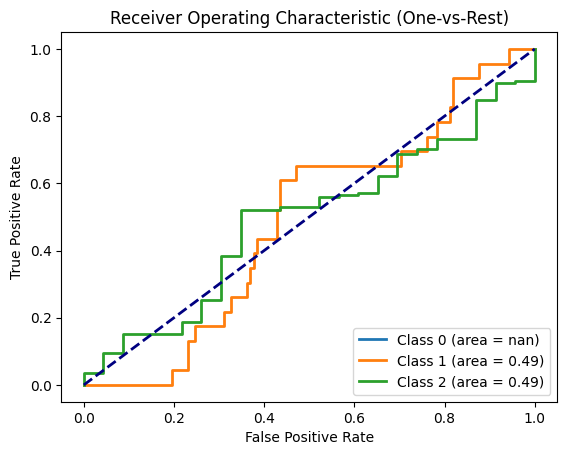

No positive class found in y_true, recall is set to one for all thresholds.


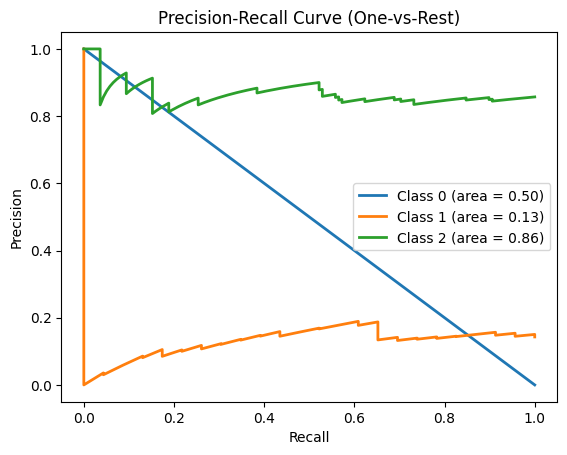

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize

# Predict labels
y_true = val_data_rgb.classes
y_pred = model_rgb.predict(val_data_rgb)
y_pred_classes = y_pred.argmax(axis=-1)

# Binarize the true labels for multi-class (One-vs-Rest)
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])  # Adjust according to your class labels

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(range(3), ['Chair', 'Sofa', 'Table'], rotation=45)
plt.yticks(range(3), ['Chair', 'Sofa', 'Table'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# ROC Curve for each class (One-vs-Rest)
for i in range(3):  # Assuming 3 classes (Chair, Sofa, Table)
    fpr, tpr, thresholds = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve for each class (One-vs-Rest)
for i in range(3):  # Assuming 3 classes (Chair, Sofa, Table)
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {i} (area = {auc(recall, precision):.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (One-vs-Rest)')
plt.legend(loc='best')
plt.show()


In [ ]:
train_data_rgb_256 = datagen.flow_from_directory(
    train_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode="categorical"
)

val_data_rgb_256 = datagen.flow_from_directory(
    valid_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode="categorical"
)


Found 454 images belonging to 3 classes.
Found 161 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build CNN model for 256x256 RGB images
model_rgb_256 = Sequential([
    # First Convolutional Layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the data
    Flatten(),

    # Fully Connected Layer
    Dense(256, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting

    # Output Layer for 3 classes (Chair, Sofa, Table)
    Dense(3, activation='softmax')
])

# Compile the model
model_rgb_256.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_rgb_256.summary()


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,585,475 (112.86 MB)

 Trainable params: 29,585,475 (112.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the CNN model with the RGB 256x256 images
history_rgb_256 = model_rgb_256.fit(
    train_data_rgb_256,
    validation_data=val_data_rgb_256,
    epochs=25  # Adjust epochs based on your model's performance
)


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 718ms/step - accuracy: 0.4320 - loss: 3.1115 - val_accuracy: 0.1366 - val_loss: 1.3939
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 300ms/step - accuracy: 0.7720 - loss: 0.5951 - val_accuracy: 0.6398 - val_loss: 0.8088
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 382ms/step - accuracy: 0.8524 - loss: 0.4337 - val_accuracy: 0.2671 - val_loss: 1.8168
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 304ms/step - accuracy: 0.9041 - loss: 0.2349 - val_accuracy: 0.3168 - val_loss: 2.1468
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - accuracy: 0.9446 - loss: 0.1560 - val_accuracy: 0.4907 - val_loss: 1.8622
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 342ms/step - accuracy: 0.9797 - loss: 0.0656 - val_accuracy: 0.4286 - val_loss: 3.1785
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 296ms/step - accuracy: 0.9890 - loss: 0.0403 - val_accuracy: 0.6646 - val_loss: 1.1238
Epoch 8/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.9959 - loss: 0.0425 - val_accuracy: 0

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step


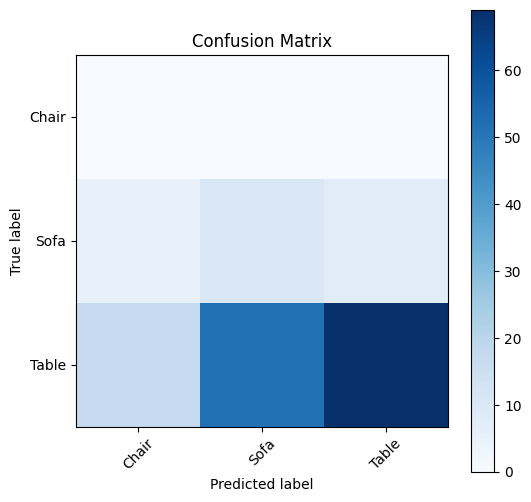

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict on the validation data
y_true = val_data_rgb_256.classes
y_pred = model_rgb_256.predict(val_data_rgb_256)
y_pred_classes = y_pred.argmax(axis=-1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(3), ['Chair', 'Sofa', 'Table'], rotation=45)
plt.yticks(np.arange(3), ['Chair', 'Sofa', 'Table'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


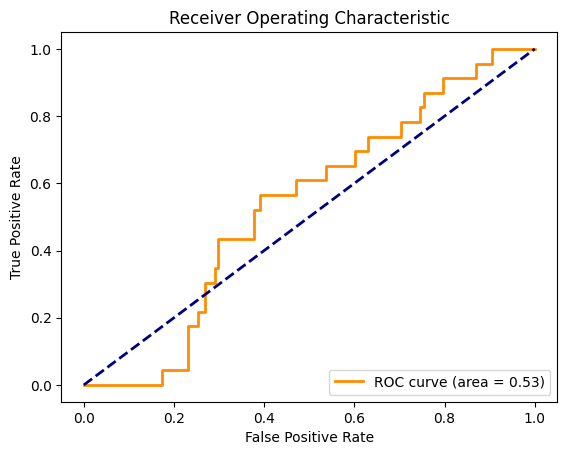

In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC Curve for each class
fpr, tpr, thresholds = roc_curve(y_true, y_pred[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


No positive class found in y_true, recall is set to one for all thresholds.


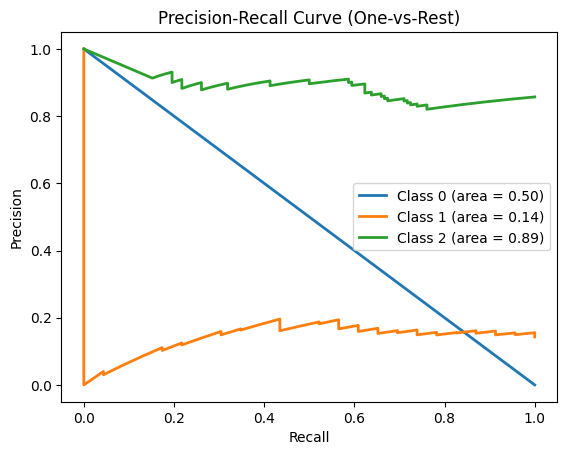

In [ ]:
for i in range(3):  # Assuming 3 classes (Chair, Sofa, Table)
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {i} (area = {auc(recall, precision):.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (One-vs-Rest)')
plt.legend(loc='best')
plt.show()

In [ ]:
from scipy import stats

# Example of accuracy for different classes
accuracy_class_1 = 0.8  # Example value for Chair
accuracy_class_2 = 0.75  # Example value for Sofa
accuracy_class_3 = 0.85  # Example value for Table

# Perform a one-way ANOVA
f_stat, p_value = stats.f_oneway([accuracy_class_1], [accuracy_class_2], [accuracy_class_3])
print(f"ANOVA F-statistic: {f_stat}, P-value: {p_value}")


ANOVA F-statistic: nan, P-value: nan


all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.


In [ ]:
# Type I (false positive) and Type II (false negative) errors
false_positive = cm[0][1] + cm[0][2]  # Incorrect predictions for class 0
false_negative = cm[1][0] + cm[2][0]  # Incorrect predictions for class 1 and 2
print(f"Type I Error: {false_positive}")
print(f"Type II Error: {false_negative}")


Type I Error: 0
Type II Error: 22


In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

train_data_gray = datagen.flow_from_directory(
    train_path,
    target_size=(250, 250),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical"
)

val_data_gray = datagen.flow_from_directory(
    valid_path,
    target_size=(250, 250),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical"
)


Found 454 images belonging to 3 classes.
Found 161 images belonging to 3 classes.


In [ ]:
# Build CNN model for 250x250 grayscale images
model_gray = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_gray.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_gray = model_gray.fit(train_data_gray, validation_data=val_data_gray, epochs=25)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 482ms/step - accuracy: 0.4867 - loss: 6.2391 - val_accuracy: 0.1180 - val_loss: 1.2738
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 412ms/step - accuracy: 0.7754 - loss: 0.6774 - val_accuracy: 0.1988 - val_loss: 1.4088
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - accuracy: 0.8328 - loss: 0.4222 - val_accuracy: 0.4720 - val_loss: 1.1101
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.9028 - loss: 0.3075 - val_accuracy: 0.3230 - val_loss: 1.3069
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 405ms/step - accuracy: 0.9564 - loss: 0.1679 - val_accuracy: 0.3913 - val_loss: 1.5957
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - accuracy: 0.9628 - loss: 0.1349 - val_accuracy: 0.5714 - val_loss: 1.1806
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 353ms/step - accuracy: 0.9871 - loss: 0.0828 - val_accuracy: 0.2981 - val_loss: 3.3170
Epoch 8/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 354ms/step - accuracy: 0.9773 - loss: 0.0907 - val_accuracy: 0

In [ ]:
train_data_gray_256 = datagen.flow_from_directory(
    train_path,
    target_size=(256, 256),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical"
)

val_data_gray_256 = datagen.flow_from_directory(
    valid_path,
    target_size=(256, 256),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical"
)


Found 454 images belonging to 3 classes.
Found 161 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build CNN model for 256x256 grayscale images
model_gray_256 = Sequential([
    # First Convolutional Layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the data
    Flatten(),

    # Fully Connected Layer
    Dense(256, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting

    # Output Layer for 3 classes (Chair, Sofa, Table)
    Dense(3, activation='softmax')
])

# Compile the model
model_gray_256.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_gray_256.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,584,899 (112.86 MB)

 Trainable params: 29,584,899 (112.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the CNN model with the grayscale 256x256 images
history_gray_256 = model_gray_256.fit(
    train_data_gray_256,
    validation_data=val_data_gray_256,
    epochs=25  # You can adjust the number of epochs based on your model's performance
)


Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 518ms/step - accuracy: 0.3987 - loss: 1.7447 - val_accuracy: 0.1118 - val_loss: 1.6004
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 466ms/step - accuracy: 0.8021 - loss: 0.5857 - val_accuracy: 0.1491 - val_loss: 1.9983
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 308ms/step - accuracy: 0.8484 - loss: 0.3991 - val_accuracy: 0.3354 - val_loss: 1.2610
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 342ms/step - accuracy: 0.8970 - loss: 0.2814 - val_accuracy: 0.3727 - val_loss: 1.7755
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 402ms/step - accuracy: 0.9645 - loss: 0.1510 - val_accuracy: 0.5280 - val_loss: 1.2969
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.9828 - loss: 0.1176 - val_accuracy: 0.6149 - val_loss: 1.1925
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 396ms/step - accuracy: 0.9915 - loss: 0.0661 - val_accuracy: 0.5217 - val_loss: 2.0414
Epoch 8/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 343ms/step - accuracy: 0.9881 - loss: 0.0332 - val_accuracy: 0

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step


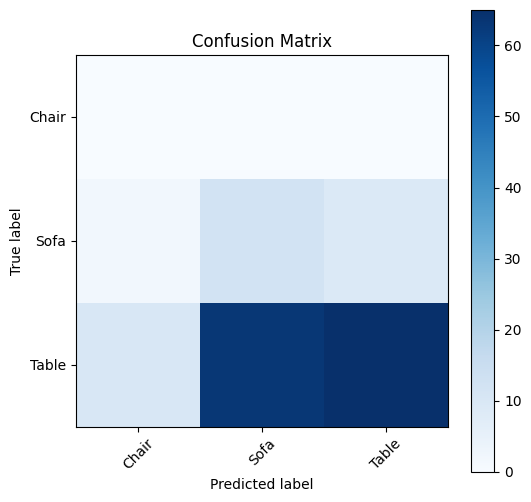

No positive samples in y_true, true positive value should be meaningless


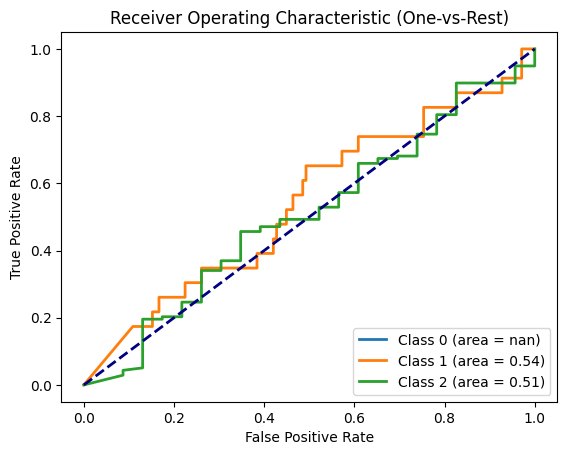

No positive class found in y_true, recall is set to one for all thresholds.


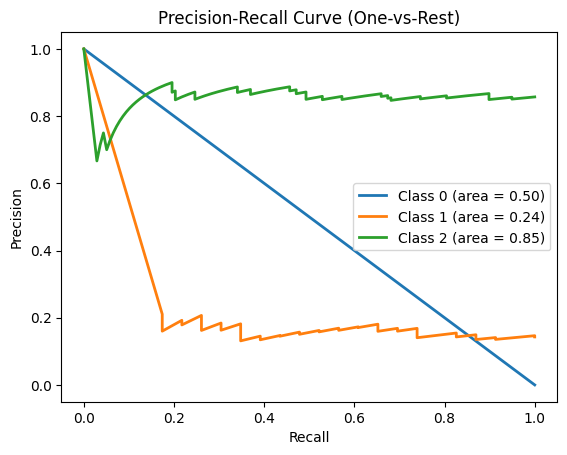

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import numpy as np

# Predict on the validation data
y_true = val_data_gray_256.classes
y_pred = model_gray_256.predict(val_data_gray_256)
y_pred_classes = y_pred.argmax(axis=-1)

# Binarize the true labels for multi-class (One-vs-Rest)
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])  # Adjust according to your class labels

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(3), ['Chair', 'Sofa', 'Table'], rotation=45)
plt.yticks(np.arange(3), ['Chair', 'Sofa', 'Table'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# ROC Curve for each class
for i in range(3):  # Assuming 3 classes (Chair, Sofa, Table)
    fpr, tpr, thresholds = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve for each class (One-vs-Rest)
for i in range(3):  # Assuming 3 classes (Chair, Sofa, Table)
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {i} (area = {auc(recall, precision):.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (One-vs-Rest)')
plt.legend(loc='best')
plt.show()


In [ ]:
from scipy import stats

# Assuming you have predicted values for each class and actual values:
predicted_accuracies = [accuracy_class_1, accuracy_class_2, accuracy_class_3]  # Example accuracies
actual_accuracies = [0.60, 0.55, 0.65]  # Example actual values for each class

# Perform a one-way ANOVA
f_stat, p_value = stats.f_oneway(predicted_accuracies, actual_accuracies)
print(f"ANOVA F-statistic: {f_stat}, P-value: {p_value}")


ANOVA F-statistic: 24.000000000000046, P-value: 0.008049893100837695


In [ ]:
# Extract Type I and Type II errors from the confusion matrix
false_positive = cm[0][1] + cm[0][2]  # Incorrect predictions for class 0
false_negative = cm[1][0] + cm[2][0]  # Incorrect predictions for class 1 and 2
print(f"Type I Error: {false_positive}")
print(f"Type II Error: {false_negative}")


Type I Error: 0
Type II Error: 12


In [ ]:
loss, accuracy = model.evaluate(val_data)
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Loss: {loss:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.7094 - loss: 0.6771
Validation Accuracy: 0.7019
Validation Loss: 0.6987


In [ ]:
# Evaluate 64x64 model
val_loss_64, val_acc_64 = model.evaluate(val_data, verbose=0)
print(f"📏 64x64 Model - Validation Loss: {val_loss_64:.4f}, Accuracy: {val_acc_64:.4f}")


📏 64x64 Model - Validation Loss: 0.6987, Accuracy: 0.7019


In [ ]:
# Evaluate 250x250 model
val_loss_250, val_acc_250 = model_rgb.evaluate(val_data_rgb, verbose=0)
print(f"📏 250x250 Model - Validation Loss: {val_loss_250:.4f}, Accuracy: {val_acc_250:.4f}")


📏 250x250 Model - Validation Loss: 4.0198, Accuracy: 0.5155


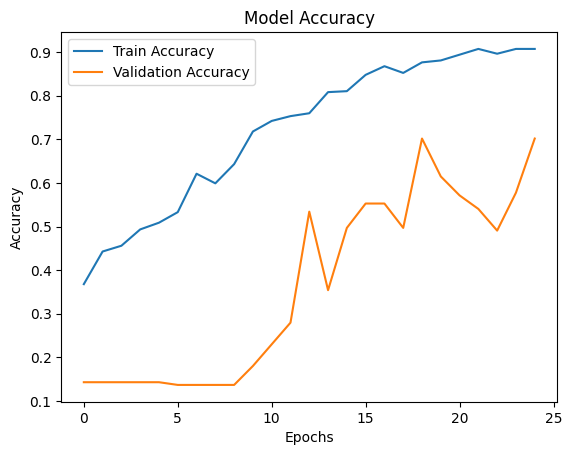

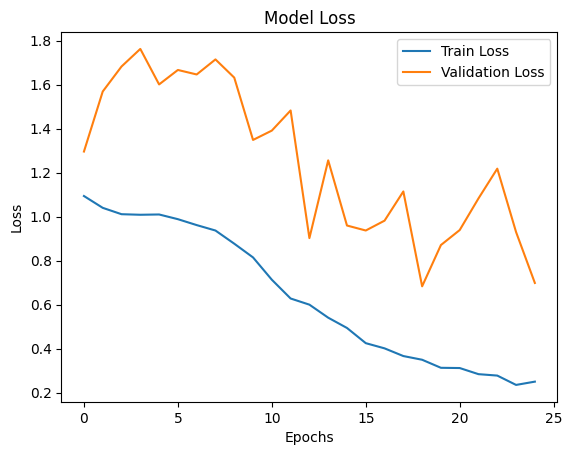

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


In [ ]:
import os
valid_path = "/content/furniture-2/valid"

print("Files in validation folder:")
print(os.listdir(valid_path))


Files in validation folder:
['Chair', 'Sofa', 'Table']


In [ ]:
model.save("/content/my_trained_model.keras")


In [ ]:
import os

valid_path = "/content/furniture-2/valid"
print("Validation Folders:", os.listdir(valid_path))


Validation Folders: ['Chair', 'Sofa', 'Table']
